In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.cross_validation import cross_val_score
from scipy import stats
import xgboost as xgb
from sklearn.linear_model import Lasso, LassoCV, Ridge

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

In [70]:
df = pd.read_csv('input/train_custom_2.csv', index_col=0)
test = pd.read_csv('input/test_custom_2.csv',index_col=0)

In [71]:
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

def rmse_cv(model, x, y):
    return np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))

rmse_scorer = metrics.make_scorer(rmse, greater_is_better=False)

In [72]:
y = df['SalePrice']
df.drop('SalePrice',1,inplace=True)

## Linear Regression (Ridge)

In [73]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), df, y).mean() for alpha in alphas]

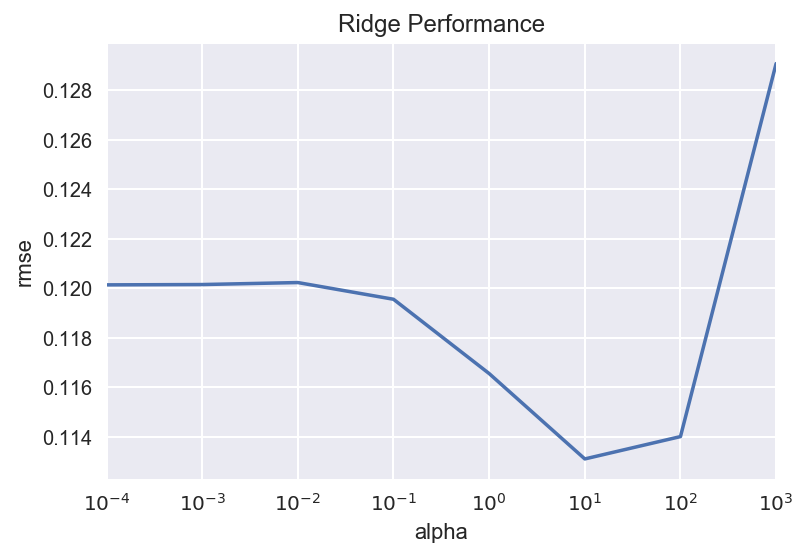

In [74]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Performance")
plt.xlabel("alpha")
plt.ylabel("rmse")
ax = plt.gca()
ax.set_xscale('log')

In [75]:
# Best Ridge RMSE
cv_ridge.min()

0.11310009356481943

In [76]:
model_ridge = Ridge(alpha=10, max_iter=50000)
model_ridge.fit(df, y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [77]:
# Run prediction on the Kaggle test set.
y_pred_ridge = model_ridge.predict(test)

## Linear Regression (LASSO)

In [78]:
# Finding alpha using SKLEARN CV
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,110,125,150,175,200]
model_lasso = LassoCV(alphas = alphas, cv=10).fit(df, y)

# Best Lasso RMSE
print rmse_cv(model_lasso,df,y).mean()
# Best Lasso alpha
print model_lasso.alpha_

0.112416525265
0.001


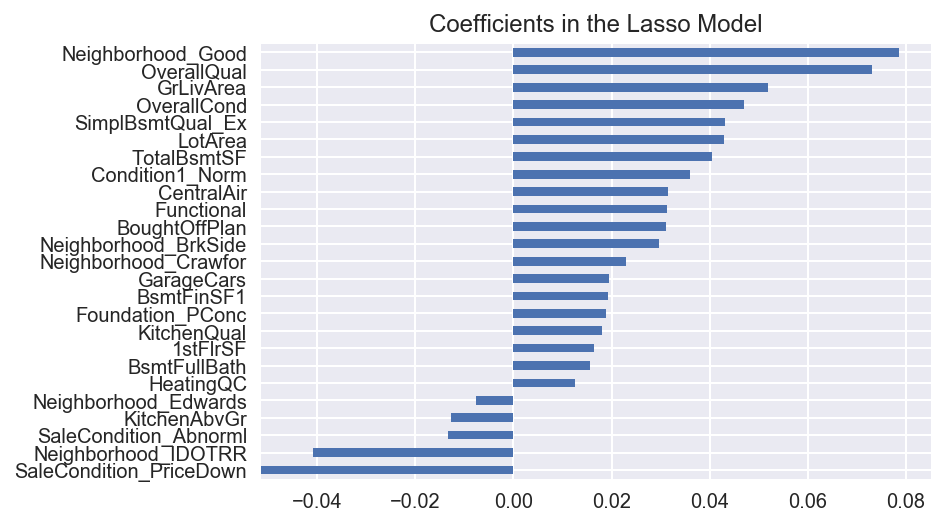

In [79]:
coef = pd.Series(model_lasso.coef_, index = test.columns)
imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(20)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [80]:
# Finding alpha using GRIDSEARCH
lasso = Lasso()
lasso_gs = model_selection.GridSearchCV(lasso, {'alpha': alphas}, cv=10,scoring=rmse_scorer)
lasso_gs.fit(df, y)

# Best Lasso RMSE
print(lasso_gs.best_score_)
# Best Lasso alpha
print(lasso_gs.best_params_)

-0.111203542093
{'alpha': 0.001}


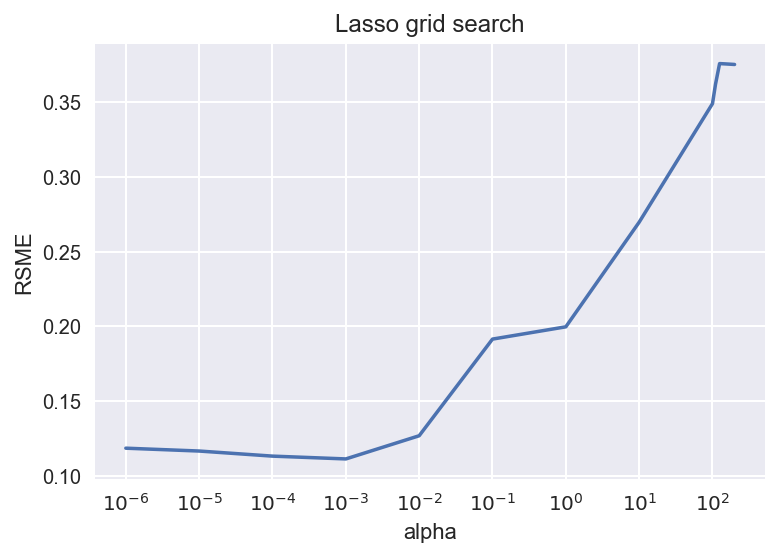

In [81]:
plt.plot([item['alpha'] for item in lasso_gs.cv_results_['params']], 
         [-item for item in lasso_gs.cv_results_['mean_test_score']])
plt.xlabel('alpha')
plt.ylabel('RSME')
plt.title('Lasso grid search')
ax = plt.gca()
ax.set_xscale('log')

In [82]:
#regr = Lasso(alpha=lasso_gs.best_params_['alpha'])
model_lasso.fit(df, y)

LassoCV(alphas=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 110, 125, 150, 175, 200],
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [83]:
# Run prediction on the Kaggle test set.
y_pred_lasso = model_lasso.predict(test)

# XGBoost

In [84]:
model_xbg = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 learning_rate=0.01,
                 max_depth=6,
                 gamma=0.0,
                 min_child_weight=9,
                 n_estimators=7000,  
                 subsample=0.6,
                 seed=42)

In [85]:
rmse_cv(model_xbg, df, y).mean()

0.1166188873456903

In [86]:
model_xbg.fit(df, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=9, missing=None, n_estimators=7000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

In [87]:
# Run prediction on the Kaggle test set.
y_pred_xgb = model_xbg.predict(test)

In [88]:
y_pred = (y_pred_lasso + y_pred_xgb) / 2
y_pred = np.expm1(y_pred)

pred_df = pd.DataFrame(y_pred, index=test.index, columns=["SalePrice"])
pred_df.to_csv('output_ensemble_norm.csv', header=True, index_label='Id')